<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM (Sin Stop Words)

### Alumna: Ariadna Garmendia

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
#!pip install --upgrade --no-cache-dir gdown --quiet

In [36]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

import seaborn as sns


### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Armar el dataset
df = pd.read_csv('dataset/clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [4]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [5]:
# Verifico que no hayan quedado Nans
df_reviews.isnull().values.any()

False

In [6]:
# Reviso las dimensiones
df_reviews.shape

(22641, 2)

In [7]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

df_reviews.Rating.value_counts()

4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64

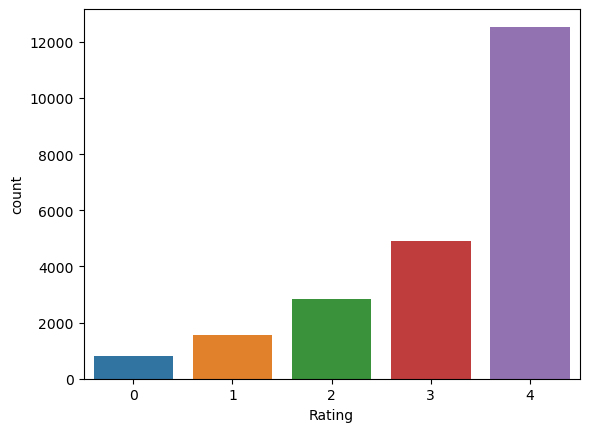

In [58]:
sns.countplot(x='Rating', data=df_reviews)
plt.show()


In [9]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['Review Text'].values
text_sequences.shape

(22641,)

In [10]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

22641

In [11]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [12]:
#corpus

In [13]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [14]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [15]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[0:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [16]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

#### Remuevo stop-words

In [17]:
# Para remover las stop-words voy a usar NLTK
import nltk
import string
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords

# Descargar tokenizador punkt
nltk.download("punkt")
# Descargar diccionario de inglés
nltk.download("wordnet")
# Descargar diccionario de stopwords
nltk.download('stopwords')
# Para usar NLTK 3.6.6 o superior es necesario instalar OMW 1.4 
# (Open Multilingual WordNet)
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/ari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/ari/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [18]:
# Stop words
nltk_stop_words = set(stopwords.words("english"))
tokens = [w for w in tokens if w not in nltk_stop_words]
# Quitar los signos de puntuacion
tokens = [w for w in tokens if w not in string.punctuation]
#print("Resultado:", tokens)
len(tokens)

670440

In [19]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000) 
tok.fit_on_texts(tokens)

In [20]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14680

In [21]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)
sequences[0][:10]

[172, 427, 796, 550, 25]

In [22]:
# Alumno: Determinar cual es la oración más larga
max(len(s) for s in sequences)

63

In [23]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 63

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [24]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 63)

In [25]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

y = pd.get_dummies(df_reviews.Rating)
print(f'Dimensión de "y": {y.shape}')
y.head()

Dimensión de "y": (22641, 5)


,0,1,2,3,4
0,0,0,0,1,0
1,0,0,0,0,1
2,0,0,1,0,0
3,0,0,0,0,1
4,0,0,0,0,1


In [26]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Verifico dimensiones
X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((22641, 63), (22641, 5), (18112, 63), (18112, 5), (4529, 63), (4529, 5))

In [28]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 5 # multiclass classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 63 , out_shape 5


### 2 - Entrenar el modelo con mis propios Embeddings + LSTM

In [29]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Bidirectional


In [30]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=64))) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-11-30 04:58:26.522216: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-30 04:58:26.522965: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 63, 50)            100050    
                                                                 
 bidirectional (Bidirectiona  (None, 63, 128)          58880     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [31]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


#### 2.1. Con dataset balanceado con Random Oversampling

In [38]:
# Voy a hacer un oversampling con SMOTE para balancear las clases
from imblearn.over_sampling import SMOTE, RandomOverSampler

ros = RandomOverSampler(random_state=10, sampling_strategy='auto')
X_resampled, y_resampled = ros.fit_resample(X_train, y_train.to_numpy()) # Paso y_train a numpy array porque daba error

X_resampled.shape, y_resampled.shape

((49975, 63), (49975, 5))

In [39]:
X_ros_train = pd.DataFrame(X_resampled)
y_ros_train = pd.DataFrame(y_resampled)

In [40]:
y_ros_train.head()

,0,1,2,3,4
0,0,0,0,1,0
1,0,0,0,0,1
2,0,0,0,0,1
3,0,1,0,0,0
4,0,0,0,0,1


#### Miro como quedan algunas de las clases luego del oversampling

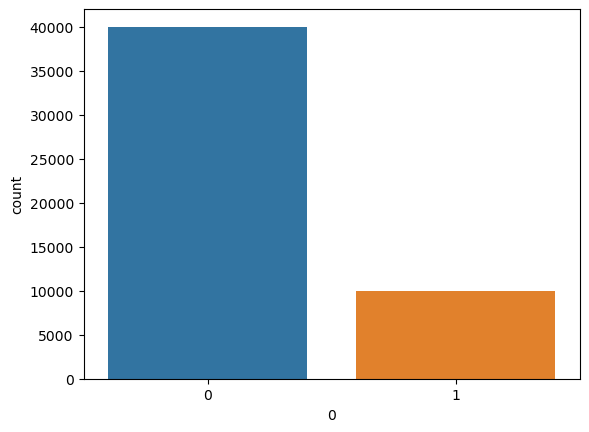

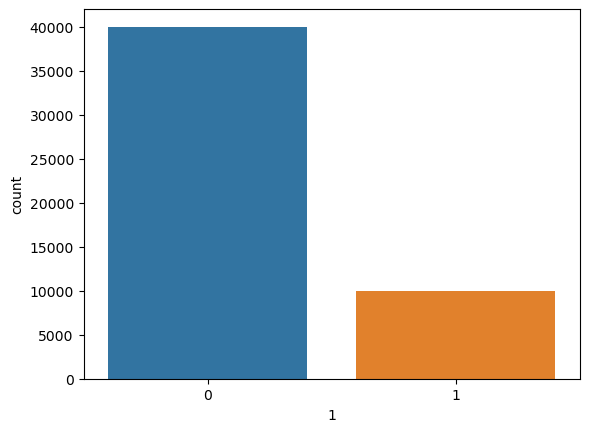

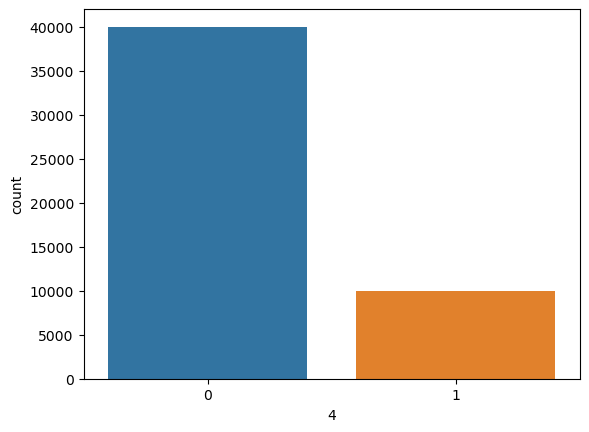

In [60]:
sns.countplot(x=0, data=y_ros_train)
plt.show()
sns.countplot(x=1, data=y_ros_train)
plt.show()
sns.countplot(x=4, data=y_ros_train)
plt.show()

In [46]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=64))) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [47]:
hist_ros = model.fit(X_ros_train, y_ros_train, epochs=35, validation_split=0.2)

Epoch 1/35


2022-11-30 12:22:21.790463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 12:22:22.342460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 12:22:22.362534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 12:22:22.586919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 12:22:22.604889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 12:22:22.894412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 12:22:22.920540: I tensorflow/core/grappler/optimizers/cust

1250/1250 [==============================] - ETA: 0s - loss: 0.9281 - accuracy: 0.6268

2022-11-30 12:23:56.999537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 12:23:57.170614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 12:23:57.183416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 12:23:57.374155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 12:23:57.387490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 111s 85ms/step - loss: 0.9281 - accuracy: 0.6268 - val_loss: 1.5821 - val_accuracy: 0.1726
Epoch 2/35
1250/1250 [==============================] - 101s 81ms/step - loss: 0.5737 - accuracy: 0.7862 - val_loss: 1.4415 - val_accuracy: 0.2700
Epoch 3/35
1250/1250 [==============================] - 251s 201ms/step - loss: 0.4542 - accuracy: 0.8313 - val_loss: 1.2990 - val_accuracy: 0.2982
Epoch 4/35
1250/1250 [==============================] - 102s 82ms/step - loss: 0.3892 - accuracy: 0.8546 - val_loss: 1.2059 - val_accuracy: 0.4030
Epoch 5/35
1250/1250 [==============================] - 101s 81ms/step - loss: 0.3517 - accuracy: 0.8678 - val_loss: 0.9847 - val_accuracy: 0.5054
Epoch 6/35
1250/1250 [==============================] - 121s 97ms/step - loss: 0.3223 - accuracy: 0.8780 - val_loss: 1.0414 - val_accuracy: 0.4961
Epoch 7/35
1250/1250 [==============================] - 101s 81ms/step - loss: 0.2871 - accuracy: 0.8889 - val_loss: 0.9297 - va

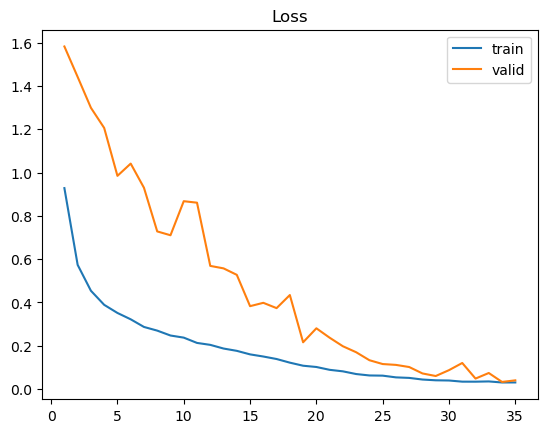

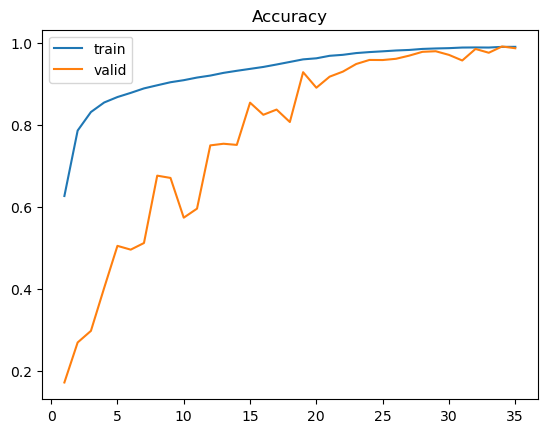

In [48]:
epoch_count = range(1, len(hist_ros.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist_ros.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist_ros.history['val_loss'], label='valid')
plt.title('Loss')
plt.show()
plt.figure()
sns.lineplot(x=epoch_count,  y=hist_ros.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist_ros.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.show()

In [49]:
model.evaluate(X_test, y_test)

2022-11-30 15:21:32.618305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 15:21:32.906538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 15:21:32.926522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 15:21:33.153153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 15:21:33.167818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - 8s 45ms/step - loss: 3.4796 - accuracy: 0.5493


[3.4795708656311035, 0.5493486523628235]

#### 2.3. Balanceado con class-weights

#### Calculo los class_weights con Sklearn, a partir de y_train

In [ ]:
from sklearn.utils import class_weight

_ ,_, y_train_cw, _ = train_test_split(X, df_reviews.Rating, test_size=0.2, random_state=42) # Hago esto de nuevo para tomar y_train_cw sin OHE

class_weights = dict(zip(np.unique(y_train_cw), class_weight.compute_class_weight(class_weight ='balanced',
                                                  classes = np.unique(y_train_cw),
                                                 y=y_train_cw)))
class_weights

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
#model.add((LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=64))) # La última capa LSTM no lleva return_sequences
#model.add((LSTM(units=64))) # La última capa LSTM no lleva return_sequences
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=out_shape, activation='softmax'))
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist1_cw = model.fit(X_train, y_train, epochs=20, validation_split=0.2, class_weight=class_weights)

Epoch 1/20
453/453 [==============================] - 16s 22ms/step - loss: 1.3758 - accuracy: 0.4280 - val_loss: 1.1384 - val_accuracy: 0.3787
Epoch 2/20
453/453 [==============================] - 8s 18ms/step - loss: 1.1864 - accuracy: 0.5276 - val_loss: 1.0683 - val_accuracy: 0.5520
Epoch 3/20
453/453 [==============================] - 8s 18ms/step - loss: 1.0681 - accuracy: 0.5741 - val_loss: 1.1040 - val_accuracy: 0.5051
Epoch 4/20
453/453 [==============================] - 8s 18ms/step - loss: 0.9773 - accuracy: 0.5913 - val_loss: 1.0870 - val_accuracy: 0.5322
Epoch 5/20
453/453 [==============================] - 8s 18ms/step - loss: 0.8948 - accuracy: 0.6130 - val_loss: 1.1643 - val_accuracy: 0.5261
Epoch 6/20
453/453 [==============================] - 8s 18ms/step - loss: 0.8333 - accuracy: 0.6276 - val_loss: 1.2085 - val_accuracy: 0.5126
Epoch 7/20
453/453 [==============================] - 8s 18ms/step - loss: 0.7785 - accuracy: 0.6404 - val_loss: 1.2290 - val_accuracy: 0.506

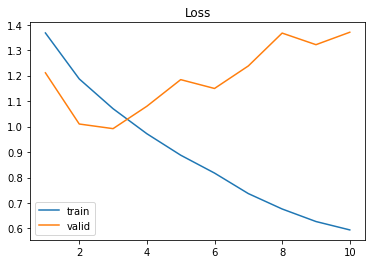

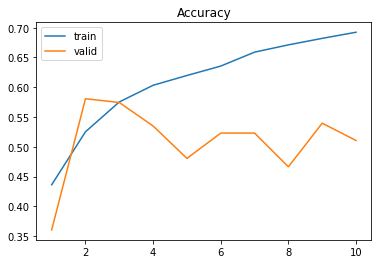

In [ ]:
epoch_count = range(1, len(hist1_cw.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist1_cw.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist1_cw.history['val_loss'], label='valid')
plt.title('Loss')
plt.show()
plt.figure()
sns.lineplot(x=epoch_count,  y=hist1_cw.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist1_cw.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 1s 9ms/step - loss: 1.3686 - accuracy: 0.5273


[1.3685506582260132, 0.5272687077522278]

### 3 - Entrenar el modelo con embeddings pre-entrenados Fasttex + LSTM


#### 3.1. Con el dataset balanceado con Random Oversampling

In [50]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [51]:
model_fasttext = FasttextEmbeddings()

In [52]:
# Crear la Embedding matrix para la cantidad nb_words seleccionadas
# nos vamos a quedar sólo con los vectores de embeddings para las palabras
# que definimos como vocabulario

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index proviene del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))

# word_index está ordenado de mayor a menor frecuencia de palabras
# las primeras que entren en el ciclo for serán las más frecuentes
# Atención! El tokenizador de Keras no tiene soporte para stop words
# las primeras palabras probablemente sean stopwords, para eliminarlas
# hay que procesar el word_index o bien elegir otra librería para preprocesamiento
# ¡ver clase 2! ;)
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words que no estén en el índice de la matriz de embedding tendrán
        # como vector de embedding correspondiente todos ceros
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [53]:
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Bidirectional


In [54]:
# Definimos el modelo

model2 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model2.add(Embedding(input_dim=vocab_size, # definido en el Tokenizador
                     output_dim=embed_dim, # dimensión de los embeddings utilizados
                     input_length=in_shape, # máxima sentencia de entrada
                     weights=[embedding_matrix], # matrix de embeddings
                    trainable=False)) # marcar como layer no entrenable

model2.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model2.add(Dropout(0.2))
model2.add(Bidirectional(LSTM(units=64))) # La última capa LSTM no lleva return_sequences

model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=out_shape, activation='softmax'))

model2.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 63, 300)           600000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 63, 128)          186880    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 63, 128)           0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)              

In [55]:
hist2_ros = model2.fit(X_ros_train, y_ros_train, epochs=35, validation_split=0.2)

Epoch 1/35


2022-11-30 15:23:04.546594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 15:23:05.107391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 15:23:05.137350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 15:23:05.442228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 15:23:05.461247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 15:23:05.795240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 15:23:05.827946: I tensorflow/core/grappler/optimizers/cust

1250/1250 [==============================] - ETA: 0s - loss: 1.4835 - accuracy: 0.3455

2022-11-30 15:24:35.104243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 15:24:35.304568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 15:24:35.317723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 15:24:35.504554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 15:24:35.519138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 108s 81ms/step - loss: 1.4835 - accuracy: 0.3455 - val_loss: 1.9398 - val_accuracy: 0.0038
Epoch 2/35
1250/1250 [==============================] - 98s 78ms/step - loss: 1.2893 - accuracy: 0.4779 - val_loss: 1.8931 - val_accuracy: 0.0142
Epoch 3/35
1250/1250 [==============================] - 94s 76ms/step - loss: 0.9112 - accuracy: 0.6474 - val_loss: 1.6050 - val_accuracy: 0.1051
Epoch 4/35
1250/1250 [==============================] - 95s 76ms/step - loss: 0.7032 - accuracy: 0.7244 - val_loss: 1.5519 - val_accuracy: 0.1670
Epoch 5/35
1250/1250 [==============================] - 97s 77ms/step - loss: 0.5904 - accuracy: 0.7666 - val_loss: 1.3570 - val_accuracy: 0.2690
Epoch 6/35
1250/1250 [==============================] - 94s 75ms/step - loss: 0.5314 - accuracy: 0.7845 - val_loss: 1.3288 - val_accuracy: 0.2561
Epoch 7/35
1250/1250 [==============================] - 94s 75ms/step - loss: 0.4867 - accuracy: 0.8029 - val_loss: 1.3212 - val_accur

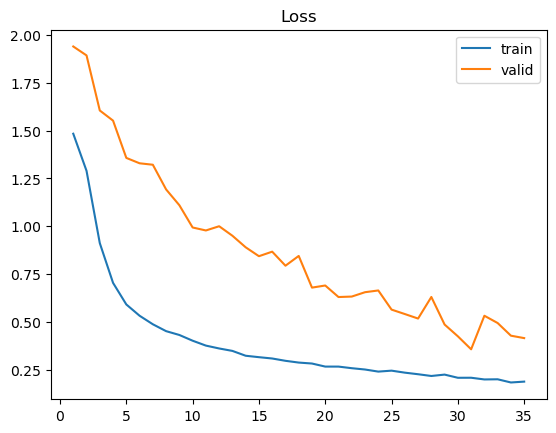

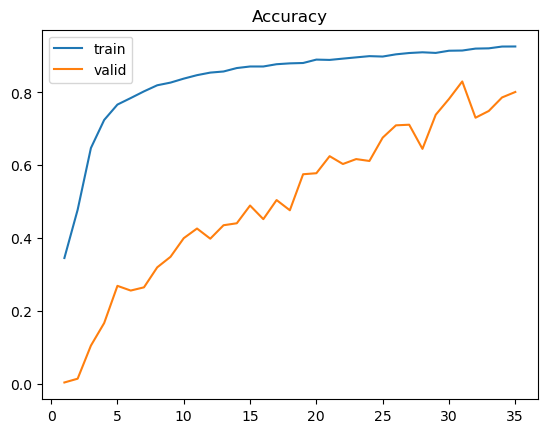

In [56]:
epoch_count = range(1, len(hist2_ros.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2_ros.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist2_ros.history['val_loss'], label='valid')
plt.title('Loss')
plt.show()
plt.figure()
sns.lineplot(x=epoch_count,  y=hist2_ros.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2_ros.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.show()

In [57]:
model2.evaluate(X_test, y_test)

2022-11-30 16:22:30.065516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 16:22:30.379875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 16:22:30.405961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 16:22:30.626118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 16:22:30.640885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - 8s 47ms/step - loss: 3.2066 - accuracy: 0.4919


[3.20660662651062, 0.49194082617759705]

### Conclusiones

#### En este caso se probó con la misma arquitectura con redes LSTM bidireccionales, pero se removieron las Stop Words. Se probó con Random Oversampling uúnicamente, que fue la técnica que mejor funcionó en la primera Notebook con stop words incluídas. 

#### Resumen de resultados:


| Prueba Nro  | Descripción | Loss       | Accuracy    | Observaciones |
| :-----------: | :----------- |:-----------:|:-----------:|:-----------:|
| 2.1.        | Con mis propios embeddings y dataset balanceado con random udersampling        | 3.4796 |0.5493| 35 epochs
| 2.2.        | Con mis propios embeddings y entrenamiento con class_weights | 1.3686 | 0.5273| 20 epochs - se observa overfitting
| 3.1.        | Con embeddings Fasttext (Fasttext) y dataset balanceado con random udersampling        | 3.2066 | 0.4919 | 35 epochs - n
